In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import hubbardml
from hubbardml import models
from hubbardml import datasets
from hubbardml import keys

random.seed(0xDEADBEEF)
torch.manual_seed(0xDEADBEEF)


dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
device, torch.get_default_dtype()

('cuda', torch.float32)

In [2]:
TEST_PERCENTAGE = 0.2

P_ELEMENT = 'p_element'
D_ELEMENT = 'd_element'
SAVEFIGS = False

TARGET_PARAM_TYPE = 'V'
# DATASET = 'data_uv_unique_inout_2022_10_13.json'

# DATASET = 'data_uv_unique_inout_2022_10_13.json'
DATASET = 'data_uv_unique_inout_2023_2_8.json'

def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

# Inputs

Load the dataset to be used

In [3]:
df = hubbardml.datasets.load(f'../data/{DATASET}')

## Filtering

Filter the DF to keep things we want

In [4]:
df = hubbardml.VGraph.prepare_dataset(df)
df = df[df[keys.PARAM_IN] > 0.5]
print(len(df))

4714


In [5]:
df[df[keys.PARAM_IN] == df.param_out]

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_1_occs_inv_2,atom_2_occs_inv_1,atom_2_occs_inv_2,param_delta,species,p_element,d_element,label,colour,sc_paths
28844,/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixN...,1_LiNiO2_v3,False,2,,"[-2.744273874, -4.7696729615999995, -0.0002036...",4,iurii,34,1.634741e+09,...,"[[0.629338, 0.000105, 3.2999999999999996e-05],...","[[1.693, -0.34700000000000003, 0.2, -0.067, 0....","[[0.6995319999999999, 0.0068460000000000005, 0...",0.0,"(O, Ni)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixN...
28845,/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixN...,1_LiNiO2_v3,False,2,,"[-2.744273874, -4.7696729615999995, -0.0002036...",4,iurii,34,1.634741e+09,...,"[[0.629338, 0.000105, 3.2999999999999996e-05],...","[[1.693, -0.34700000000000003, 0.2, -0.067, 0....","[[0.6995319999999999, 0.0068460000000000005, 0...",0.0,"(O, Ni)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/iurii/Layered/2_LixN...
44258,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C3_Li0.50FePO4,False,4,,"[19.180999039, 0.0114910955, -0.05404131499999...",26,iurii,83,1.626259e+09,...,"[[0.092721, -1e-06, -0.0, -0.0, -0.0], [-1e-06...","[[1.6989999999999998, -0.036000000000000004, 0...","[[0.7211879999999999, 0.000203, 6.3e-05], [0.0...",0.0,"(O, Fe)",O,Fe,Fe-O,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...
44465,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...,C3_Li0.50FePO4,False,4,,"[19.180999039, 0.0114910955, -0.05404131499999...",26,iurii,83,1.626259e+09,...,"[[0.7211879999999999, 0.000203, 6.3e-05], [0.0...","[[1.09, 0.0, 0.02, 0.017, 0.002], [0.0, 1.172,...","[[0.092721, -1e-06, -0.0, -0.0, -0.0], [-1e-06...",0.0,"(O, Fe)",O,Fe,Fe-O,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFeP...
53415,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,8,,"[18.754950578, 0.14624321199999998, 0.21042946...",25,iurii,96,1.619954e+09,...,"[[0.052258, -0.000132, 0.0, -0.001325, 0.0], [...","[[1.524, 0.081, 0.027], [0.081, 1.621, 0.011],...","[[0.580644, 0.0015680000000000002, 0.000182], ...",0.0,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...
53632,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,8,,"[18.754950578, 0.14624321199999998, 0.21042946...",25,iurii,96,1.619954e+09,...,"[[0.057536000000000004, -0.000429, 1.1e-05, -0...","[[1.6909999999999998, 0.0, -0.025], [0.0, 1.47...","[[0.714738, -0.00012099999999999999, 0.000144]...",0.0,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...
53848,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,8,,"[18.754950578, 0.14624321199999998, 0.21042946...",25,iurii,96,1.619954e+09,...,"[[0.580644, 0.0015680000000000002, 0.000182], ...","[[1.039, 0.029, -0.002, -0.027999999999999997,...","[[0.052258, -0.000132, 0.0, -0.001325, 0.0], [...",0.0,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...
54002,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,8,,"[18.754950578, 0.14624321199999998, 0.21042946...",25,iurii,96,1.619954e+09,...,"[[0.714738, -0.00012099999999999999, 0.000144]...","[[1.05, -0.020000000000000004, 0.012, -0.022, ...","[[0.057536000000000004, -0.000429, 1.1e-05, -0...",0.0,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...
54421,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,9,,"[18.7564918285, 0.14657487349999998, 0.2109562...",25,iurii,97,1.620056e+09,...,"[[0.057536000000000004, -0.000429, 1.1e-05, -0...","[[1.694, -0.05, 0.007000000000000001], [-0.05,...","[[0.717393, 0.000621, -0.00017], [0.000621, 0....",0.0,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...
54422,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B2_Li0.25MnPO4,False,9,,"[18.7564918285, 0.14657487349999998, 0.2109562...",25,iurii,97,1.620056e+09,...,"[[0.057536000000000004, -0.000429, 1.1e-05, -0

## Model creation

Find out which species we have to support

In [6]:
species = list(pd.concat((df[keys.ATOM_1_ELEMENT], df[keys.ATOM_2_ELEMENT])).unique())
print(f'Found species {species}')

Found species ['Ni', 'O', 'Co', 'Mn', 'Ti', 'S', 'Fe']


In [7]:
df[D_ELEMENT].value_counts()

Ni    2184
Mn    1806
Fe     702
Co      18
Ti       4
Name: d_element, dtype: int64

## Model

In [8]:
graph = hubbardml.VGraph(species)
model = hubbardml.VModel(
    graph,
    node_features="12x0e+4x1e+6x2e",
    rescaler = hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    hidden_layers=2,
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


VModel(
  (layers): ModuleList(
    (0): Gate (22x0e+4x1e+6x2e -> 12x0e+4x1e+6x2e)
    (1): TensorSquare(12x0e+4x1e+6x2e -> 22x0e+4x1e+6x2e | 3532 paths | 3532 weights)
    (2): Gate (22x0e+4x1e+6x2e -> 12x0e+4x1e+6x2e)
    (3): TensorSquare(12x0e+4x1e+6x2e -> 1x0e | 109 paths | 109 weights)
    (4): Rescaler()
  )
  (node_node_tp): FullyConnectedTensorProduct(8x0e+1x2e+2x0e+1x1e+1x2e+1x3e+1x4e x 8x0e+1x2e+1x4e+2x0e+1x1e+1x2e+1x3e+1x4e+1x0e+1x1e+1x2e+1x3e+1x4e+1x5e+1x6e+1x7e+1x8e -> 12x0e+4x1e+6x2e | 2332 paths | 2332 weights)
  (node_node_edge_tp): FullyConnectedTensorProduct(12x0e+4x1e+6x2e x 2x0e -> 22x0e+4x1e+6x2e | 632 paths | 632 weights)
)

## Split test/train

In [9]:
hubbardml.datasets.split(df, method='category', frac=0.2, category=['species'])

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_occs_inv_1,atom_2_occs_inv_2,param_delta,species,p_element,d_element,label,colour,sc_paths,training_label
643,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.374, -0.054000000000000006, -0.016], [-0.0...","[[0.471744, 0.000693, 6e-05], [0.000693, 0.683...",-0.3565,"(Ni, O)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
644,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.374, -0.054000000000000006, -0.016], [-0.0...","[[0.471744, 0.000693, 6e-05], [0.000693, 0.683...",-0.3565,"(Ni, O)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
645,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.6669999999999998, 0.028999999999999998, -0...","[[0.6947199999999999, 0.00021, 0.000192], [0.0...",-0.4453,"(Ni, O)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
646,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.6669999999999998, 0.028999999999999998, -0...","[[0.6947199999999999, 0.00021, 0.000192], [0.0...",-0.4453,"(Ni, O)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,validate
647,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.6709999999999998, 0.031, 0.033], [0.031, 1...","[[0.698058, 0.000238, 0.00027200000000000005],...",-0.4419,"(Ni, O)",O,Ni,Ni-O,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,validate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106816,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.898, 0.003000000000000001, 0.0, -0.005, 0....","[[0.17304000000000003, -0.000108, -0.0001, -2....",0.0011,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
106817,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.898, 0.0, -0.002, 0.005, 0.008], [0.0, 1.0...","[[0.17304000000000003, -0.0001, -9.89999999999...",0.0011,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
106862,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.8899999999999999, -0.006999999999999999, 0...","[[0.17670899999999998, -0.00012, -0.00012, 0.0...",0.0009,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,validate
106863,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.898, 0.003000000000000001, 0.0, -0.005, 0....","[[0.17304000000000003, -0.000108, -0.0001, -2....",0.0011,"(Mn, O)",O,Mn,Mn-O,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train


In [10]:
# Get the indices of the training and test data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.loc[train_idx]['species'].value_counts())
print(df.loc[validate_idx]['species'].value_counts())

(Ni, O)    1747
(Mn, O)    1445
(O, Fe)     562
(O, Co)      14
(S, Ti)       3
Name: species, dtype: int64
(Ni, O)    437
(Mn, O)    361
(O, Fe)    140
(O, Co)      4
(S, Ti)      1
Name: species, dtype: int64


In [11]:
trainer = hubbardml.training.Trainer.from_frame(
    model = model,
    opt = torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn = torch.nn.MSELoss(),
    frame = df
)

In [12]:
trainer._opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
trainer.overfitting_window = 600

def progress(trainer):
    print(
        f"{trainer.epoch} {trainer.training.metrics['mse']:.5f} {trainer.validation.metrics['mse']:.5f} {trainer.validation.metrics['rmse']:.4f}")

trainer.train(
    callback=progress,
    callback_period=50,
    max_epochs=1_000
)

3000 0.03329 0.03333 0.1826
3050 0.03410 0.03392 0.1842
3100 0.03297 0.03318 0.1821
3150 0.03286 0.03293 0.1815
3200 0.03273 0.03278 0.1811
3250 0.03350 0.03274 0.1809
3300 0.03250 0.03257 0.1805
3350 0.03238 0.03247 0.1802
3400 0.03225 0.03237 0.1799
3450 0.03476 0.03552 0.1885
3500 0.03197 0.03242 0.1801
3550 0.03191 0.03213 0.1792
3600 0.03180 0.03201 0.1789
3650 0.03169 0.03193 0.1787
3700 0.03183 0.03198 0.1788
3750 0.03151 0.03185 0.1785
3800 0.03139 0.03173 0.1781
3850 0.03130 0.03165 0.1779
3900 0.03230 0.03510 0.1874
3950 0.03110 0.03177 0.1783


'max_epochs'

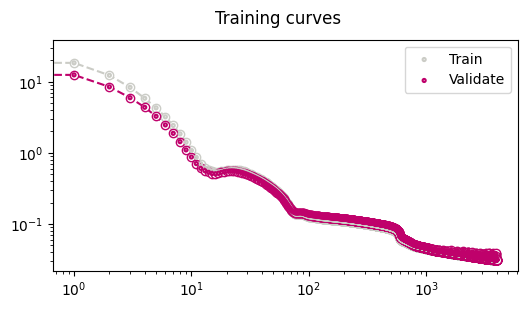

In [37]:
trainer.plot_training_curves();

In [38]:
predicted = model(trainer.validation_data.all_inputs()).detach().cpu().numpy().reshape(-1)
input_train = model(trainer.training_data.all_inputs()).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = input_train

In [39]:
df_test = df.loc[validate_idx]
test_rmse = hubbardml.datasets.rmse(df)

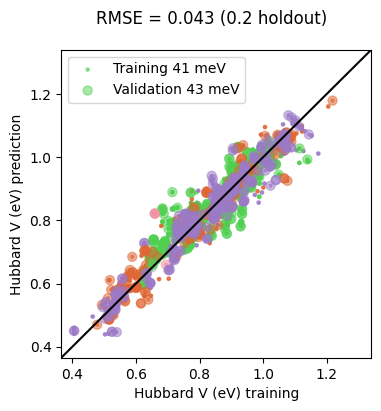

In [40]:
hubbardml.plots.create_parity_plot(
    df,
    axis_label='Hubbard V (eV)',
    title=f'RMSE = {test_rmse:.3f} ({TEST_PERCENTAGE} holdout)'
);

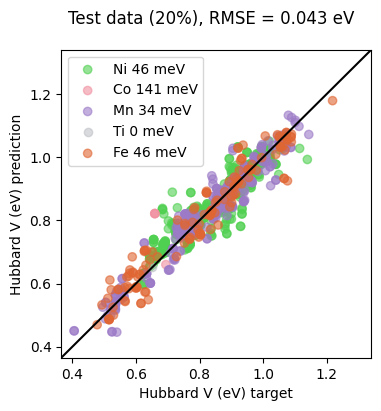

In [41]:
fig = hubbardml.plots.split_plot(
    df_test, D_ELEMENT,
    axis_label='Hubbard V (eV)',
    title=f'Test data ({TEST_PERCENTAGE * 100:.0f}%), RMSE = {test_rmse:.3f} eV'
);
if SAVEFIGS:
    fig.savefig(plotfile('+V_parity_species'), bbox_inches='tight')

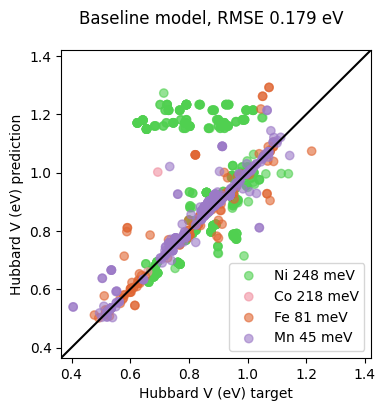

In [42]:
df_ref = df_test.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = hubbardml.plots.split_plot(
    df_ref,
    D_ELEMENT,
    axis_label='Hubbard V (eV)',
    title=f'Baseline model, RMSE {hubbardml.datasets.rmse(df_ref):.3f} eV'
);
if SAVEFIGS:
    fig.savefig(plotfile('+V_parity_species_ref'), bbox_inches='tight')

TypeError: 'AxesSubplot' object is not subscriptable

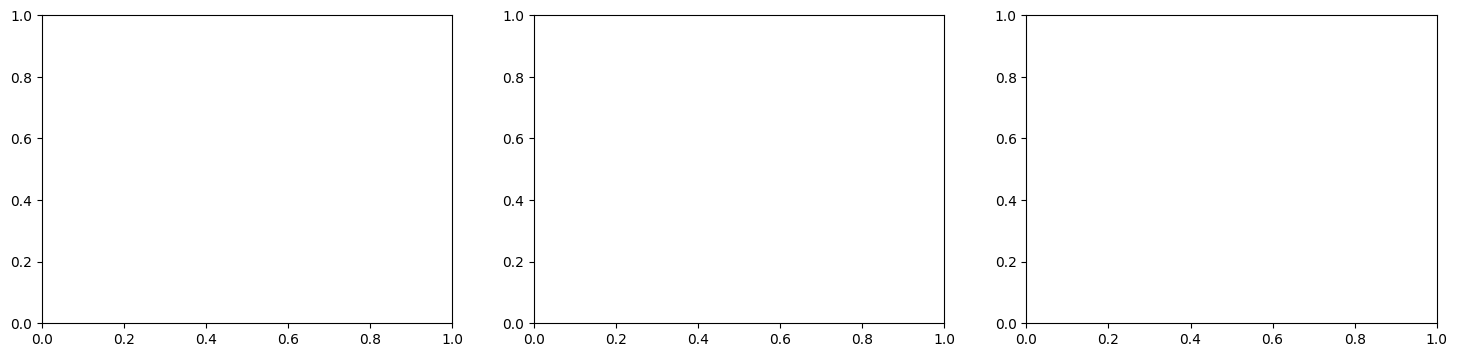

In [21]:
dirs = set()
for directory in df['dir'].unique():
    dirs.add('/'.join(directory.split('/')[:-1]))

res = []
for directory in dirs:
    res.append(hubbardml.plots.create_progression_plots(df[df['dir'].str.startswith(directory)], yrange=0.4))

In [22]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_v/steps_{idx}_+V.pdf', bbox_inches='tight')
            idx += 1
